In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

!pip install opencv-python

In [2]:
import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
import gc
from tqdm import tqdm
import pandas as pd
import seaborn as sb
from pandas import DataFrame
from scipy.spatial import distance
from scipy.cluster import hierarchy
from torchvision.transforms import Resize
import dill
from joblib import Parallel, delayed
# import cv2
import resource
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import tifffile

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import babelfish as bf
from babelfish.volume import Vol2D
from babelfish.resnet import ResNet, BasicBlock
from babelfish.super_res import SuperResBlock
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from babelfish.misc import sigmoid_schedule
import time
import logging
logger = logging.getLogger('babelfish')

torch.manual_seed(2223)

In [3]:
# 512 x 512
# imaging = tifffile.imread("/data2/2019_ye_voltage/4-1.tif")[:,None,None,:,(640-512):]
imaging = tifffile.imread("/data/dlab/2019_ye_voltage/4-1.tif")[:,:,(640-512):]
print(imaging.min(), np.log2(imaging.max()))
# scale to 0:1
# imaging = imaging / 2**16
imaging = np.log(imaging+1)

0 15.999912


In [4]:
np.percentile(imaging,3)

7.060476303100586

Text(0, 0.5, 'pixel value')

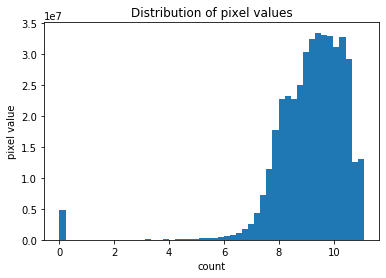

In [5]:
plt.title("Distribution of pixel values")
plt.hist(imaging.reshape(-1),bins=50)
plt.xlabel("count")
plt.ylabel("pixel value")

In [8]:
class VideoData(Dataset):
    "B x nFrames x Z x H x W"
    def __init__(self, imaging,
                 index_map=None, prev_frames=2, next_frames=1):
#         data = imaging - imaging.mean(0)
        data = imaging
        # use channel for future / prev frames
        self.data = T.from_numpy(data)
        self.prev_frames = prev_frames
        self.next_frames = next_frames
        self.index_map = index_map

    def __len__(self):
        if self.index_map:
            return len(self.index_map)
        else:
            return self.data.shape[0]-self.prev_frames - self.next_frames + 1

    def __getitem__(self, i):
        "X[0]==X_i, X[1]==X_i-1, Y[0]==Y_i+1, Y[1]==Y_i+2"
        if self.index_map:
            idx = self.index_map[i]
        else:
            idx = i + self.prev_frames - 1 # avoid wraparound
        X = {"brain": []}
        Y = {"brain": []}
        for i in reversed(range(self.prev_frames)):
            ix = idx-i
            X["brain"].append(self.data[ix])
        for i in range(1,self.next_frames+1):
            ix = idx+i
            Y["brain"].append(self.data[ix])
        X = {k: T.stack(v,0) for k,v in X.items()}
        Y = {k: T.stack(v,0) for k,v in Y.items()}
        return X, Y

In [9]:
prev_frames = 5
next_frames = 2
small_imaging = bf.helpers.resize_volume(imaging.astype(np.float32),0.5,0.5)[:,None]
train_data = VideoData(small_imaging, prev_frames=prev_frames, next_frames=next_frames)

In [10]:
_, nZ, H, W = train_data[0][0]["brain"].shape

In [11]:
import torch as T
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
#         self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
#         self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
#         out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
#         out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, prev_frames=1):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(prev_frames, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1) # for full-size images
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 64, layers[3], stride=2)
#         self.avgpool = nn.AvgPool2d(8, stride=1)
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # 232 x 512
        logger.debug("x", x.shape)
        x = self.conv1(x)
        logger.debug("conv1", x.shape)
#         x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        logger.debug("pool1", x.shape)
#         logger.debug(x.shape)
        # 58 x 128

        x = self.layer1(x)
        logger.debug("layer1", x.shape)
        # 29 x 64
        x = self.layer2(x)
        logger.debug("layer2", x.shape)
        # 15 x 32
        x = self.layer3(x)
        logger.debug("layer3", x.shape)
        # 8 x 16
        x = self.layer4(x)
        logger.debug("layer4", x.shape)
        # 4 x 8
        x = x.view(x.shape[0],x.shape[1],-1).mean(2)
        # 1 x 1
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
        return x


In [25]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def unit_norm_KL_divergence(mu, logvar):
    "Reconstruction + KL divergence losses summed over all elements and batch."
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return -0.5 * T.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # tf
#     logpz = log_normal_pdf(z, 0., 0.)
#     logqz_x = log_normal_pdf(z, mean, logvar)
#     return -tf.reduce_mean(logpz - logqz_x)

def pz_kl_divergence(mu, logvar):
    mean = mu.mean()
    std = mu.std()
    return torch.sum(0.5 * (mean**2 + std**2 - 1) - T.log(std))

class Conv_Latent_Pred(Vol2D):
    def __init__(self, nZ=11, H=232, W=512, nEmbedding=20, prev_frames=1, next_frames=5, nContext=100,
                 tensor=T.cuda.FloatTensor, verbose=False):
        super(Conv_Latent_Pred, self).__init__(tensor)
        self.tensor = tensor
        self.nZ = nZ
        self.H = H
        self.W = W
        self.lowH = 8
        self.lowW = 8
        self.lowFeatures = 1
        self.prev_frames = prev_frames
        self.next_frames = next_frames
        self.verbose = verbose
        # batch x channel x Z x H x W
        # Encoding
        self.resnet = ResNet(BasicBlock, [2, 2, 2, 2], 1)
        self.resOut = 64
        self.nEmbedding = nEmbedding

        self.encoding_mean = nn.Linear(self.resOut*self.nZ, nEmbedding)
        self.encoding_logvar = nn.Linear(self.resOut*self.nZ, nEmbedding)
        self.encoding_context = nn.GRU(nEmbedding, nContext, batch_first=True)
        # 0 is predict 1 timestep, k is predict k-1 timesteps
        pred_fns = [nn.Linear(nContext, nEmbedding) for k in range(next_frames)]
        self.predict_step = T.nn.ModuleList(pred_fns)


        # Decoding
        self.activation = nn.Tanh()
        self.decoding = nn.Linear(nEmbedding,self.lowFeatures*nZ*self.lowH*self.lowW)
        self.upconv1 = SuperResBlock(2,1,tensor)
        # 11 x 16 x 32
        self.upconv2 = SuperResBlock(2,1,tensor)
        # 11 x 32 x 64
        self.upconv3 = SuperResBlock(2,1,tensor)
        # 11 x 64 x 128
        self.upconv4 = SuperResBlock(2,1,tensor)
        # 11 x 128 x 256
        self.upconv5 = SuperResBlock(2,1,tensor)
        # 11 x 256 x 512


    def sample_embedding(self, mu, logvar):
        if self.training:
            std = T.exp(0.5*logvar)
            eps = T.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def encode(self, x, collapse_time=True):
        logger.debug("x",x.shape)
        shape = x.shape
        if collapse_time:
            # collapse batch x time to batch
            x = x.view(-1,1,*shape[2:])
            if self.verbose:
                print("x re", x.shape)
        x = x.transpose(1,2)
        out = self.tensor(x.shape[0],x.shape[1],self.resOut)
        for z in range(x.shape[1]):
            out[:,z] = self.resnet(x[:,z])
        mean = self.encoding_mean(out.reshape(x.shape[0],-1))
        logvar = self.encoding_logvar(out.reshape(x.shape[0],-1))

        if collapse_time:
            # restore batch to batch x time
            mean = mean.view(*shape[0:2], self.nEmbedding)
            logvar = logvar.view(*shape[0:2], self.nEmbedding)
            if self.verbose:
                print("mean",mean.shape)
        return mean, logvar

    def decode(self, z, collapse_time=True):
        # z is for latent, not spatial dimension
        logger.debug("z", z.shape)
        shape = z.shape
        if collapse_time:
            # collapse batch x time to batch
            z = z.view(-1,1,*shape[2:])

            if self.verbose:
                print("z", z.shape)

        # b x 10
        z = self.activation(self.decoding(z))
        logger.debug("decoding", z.shape)
        z = z.reshape(z.shape[0],self.nZ,self.lowFeatures,self.lowH,self.lowW)
        logger.debug("decoding reshape", z.shape)
        logger.debug("upconv1", z.shape)
        z = self.upconv1(z)
        logger.debug("upconv2", z.shape)
        z = self.upconv2(z)
        logger.debug("upconv3", z.shape)
        z = self.upconv3(z)
        logger.debug("upconv4", z.shape)
        z = self.upconv4(z)
        z = self.upconv5(z)
        z = self.crop(z[:,:,0])
        # squeeze channel
        logger.debug("z", z.shape)
        if collapse_time:
            # restore batch to batch x time
            z = z.view(*shape[0:2], *z.shape[1:])
        return z

    def predict(self, zs):
        logger.debug("zs", zs.shape)
        context = self.encoding_context(zs)[0][:,-1] # last output only
        logger.debug("context",context.shape)
        preds = [self.predict_step[k](context) for k in range(self.next_frames)]
        return T.stack(preds,1)


    def forward(self, x, collapse_time=True):
        "Return Previous volume (denoised), next volume (prediction), latent mean and logvar."
        # batch x time x ...
        mean, logvar = self.encode(x, collapse_time=collapse_time)
        predicted = self.predict(mean)
        encoded = self.sample_embedding(mean, logvar)
        decoded = self.decode(encoded,collapse_time=collapse_time)
        return predicted, decoded, mean, logvar

def train(model,train_data,valid_data, nepochs=10, lr=1e-3, kl_lambda=1, tail_lambda=1e2, half=False, pred_lambda=1,
          cuda=True, batch_size=16, num_workers=8):
    global e
    global avg_Y_loss
    global avg_Y_val_loss
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
#     valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    optimizer = T.optim.Adam(model.parameters(),lr=lr)
    kl_schedule = T.from_numpy(sigmoid_schedule(nepochs)).cuda()
#     kl_schedule[0] = 1e-10
    for e in range(nepochs):
        print("epoch {}: ".format(e), end="")
        cum_loss = 0
        cum_Y_loss = 0
        cum_kl_loss = 0
        cum_predict_loss = 0
        for b,batch_data in enumerate(tqdm(dataloader)):
            # X is prev, Y is pred
            X = batch_data[0]["brain"]
            logger.debug("X", X.shape)
            Y = batch_data[1]["brain"]
            X = X.cuda()
            Y = Y.cuda()
            # latent
            predicted, Xhat, Xz_mean, Xz_logvar = model(X)
            Yz_mean, Yz_logvar = model.encode(Y)
#             print("embedding", embedding.shape)
#             mse_Y = F.mse_loss(Y_pred, Y[:,-1], reduction='mean')
            mean = T.cat([Xz_mean.view(-1,Xz_mean.shape[2]),
                          Yz_mean.view(-1,Yz_mean.shape[2])])
            logvar = T.cat([Xz_logvar.view(-1,Xz_logvar.shape[2]),
                            Yz_logvar.view(-1,Yz_logvar.shape[2])])
            logger.debug("X",X.shape,"prdec", predicted.shape, Yz_mean.shape)
#             reconst_loss = F.poisson_nll_loss(Xhat, X)
            reconst_loss = F.mse_loss(Xhat, X)
#             reconst_loss = F.binary_cross_entropy_with_logits(
#                 Xhat, X, reduction='sum')
            predict_loss = F.mse_loss(predicted, Yz_mean, reduction='mean')
            kld = unit_norm_KL_divergence(mean, logvar)
#             kld = pz_kl_divergence(mean, logvar)

#             loss = reconst_loss + kl_lambda*kl_schedule[e] * kld
            loss = reconst_loss + pred_lambda*predict_loss \
                + kl_lambda*kl_schedule[e]*kld
            if e==0 and (b % 10 == 0 or b < 10):
                print(f"Reconstruction: {float(reconst_loss):.3E}, KLD: {float(kld):.3E}, predict_loss: {float(predict_loss)}")
            optimizer.zero_grad()
            loss.backward()
            T.nn.utils.clip_grad_norm_(model.parameters(), 1000)
            optimizer.step()
            cum_loss += float(loss)
            cum_Y_loss += float(reconst_loss)
            cum_kl_loss += float(kld)
            cum_predict_loss += float(predict_loss)

        avg_Y_loss = cum_Y_loss/len(train_data)
        print("avg_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, Pred: {:3E}".format(
            cum_loss/len(train_data), avg_Y_loss, cum_kl_loss, cum_predict_loss))
        cum_loss = 0
        cum_Y_loss = 0
        cum_predict_loss = 0
        cum_kl_loss = 0
#         model.eval()
#         for batch_data in valid_dataloader:
#             X, Y = batch_data
#             X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
#             Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
#             if cuda:
#                 X = X.cuda()
#                 Y = Y.cuda()
#                 X_shock = X_shock.cuda()
#                 Y_shock = Y_shock.cuda()
#                 X_tail = X_tail.cuda()
#                 Y_tail = Y_tail.cuda()
#             (Y_pred, Y_pred_tail), embedding = model(X, Y_shock)
#             if half:
#                 Y_pred = Y_pred.float()
#                 mean = mean.float()
#                 logvar = logvar.float()
#             mse_Y = F.mse_loss(Y_pred, Y[:,-1])
#             mse_tail = F.mse_loss(Y_pred_tail, Y_tail[:,[-1]])
#             loss = mse_Y + tail_lambda*mse_tail + sparse_lambda * embedding.norm(1)
#             cum_loss += float(loss)
#             cum_Y_loss += float(mse_Y)
#             cum_tail_loss += float(mse_tail)
#         model.train()
#         avg_Y_valid_loss = cum_Y_loss/len(valid_data)
#         print("VALIDATION: avg_loss: {:3E}, Y_loss: {:3E}, tail_loss: {:3E}".format(
#             cum_loss/len(valid_data), avg_Y_valid_loss, cum_tail_loss/len(valid_data)))
    return avg_Y_loss#, avg_Y_valid_loss

gc.collect()
T.cuda.empty_cache()

# parallel_model = nn.DataParallel(model)
gen = False
# gen = True
cuda=True
# cnmf=True
cnmf=False
half=True
half=False
multi_gpu = True
num_workers = 0 # only zero worker in Docker
kl_lambda = 1e-0
pred_lambda = 1e-0
lr=1e-3
nepochs = 5
nEmbedding = 2
# batch_size = 6
batch_size = 16
# batch_size = 8192
# batch_size = 8192

model = Conv_Latent_Pred(nZ=1, H=H, W=W, nEmbedding=nEmbedding, prev_frames=prev_frames,
                         next_frames=next_frames)
model.cuda()

train(model,train_data,None,nepochs,lr=lr, half=half, cuda=cuda, kl_lambda=kl_lambda,
      pred_lambda=pred_lambda, num_workers=num_workers, batch_size=batch_size)


  0%|          | 0/102 [00:00<?, ?it/s]

epoch 0: Reconstruction: 8.433E+01, KLD: 5.999E+09, predict_loss: 26.001220703125


  1%|          | 1/102 [00:00<00:40,  2.48it/s]

Reconstruction: 8.384E+01, KLD: 1.162E+04, predict_loss: 81.84644317626953


  2%|▏         | 2/102 [00:00<00:39,  2.51it/s]

Reconstruction: 8.216E+01, KLD: 7.659E+03, predict_loss: 58.315181732177734


  3%|▎         | 3/102 [00:01<00:38,  2.54it/s]

Reconstruction: 8.036E+01, KLD: 9.622E+02, predict_loss: 0.11751512438058853


  4%|▍         | 4/102 [00:01<00:38,  2.56it/s]

Reconstruction: 7.859E+01, KLD: 4.992E+02, predict_loss: 1.0791587829589844


  5%|▍         | 5/102 [00:01<00:37,  2.58it/s]

Reconstruction: 7.657E+01, KLD: 2.374E+02, predict_loss: 0.2397037148475647


  6%|▌         | 6/102 [00:02<00:36,  2.60it/s]

Reconstruction: 7.466E+01, KLD: 2.063E+02, predict_loss: 0.43864706158638


  7%|▋         | 7/102 [00:02<00:36,  2.61it/s]

Reconstruction: 7.245E+01, KLD: 2.631E+02, predict_loss: 1.009387731552124


  8%|▊         | 8/102 [00:03<00:35,  2.62it/s]

Reconstruction: 7.020E+01, KLD: 1.012E+02, predict_loss: 0.5105786323547363


  9%|▉         | 9/102 [00:03<00:35,  2.62it/s]

Reconstruction: 6.780E+01, KLD: 6.705E+01, predict_loss: 0.28505438566207886


 10%|▉         | 10/102 [00:03<00:35,  2.62it/s]

Reconstruction: 6.548E+01, KLD: 4.161E+01, predict_loss: 0.05686890333890915


 20%|█▉        | 20/102 [00:07<00:28,  2.92it/s]

Reconstruction: 4.283E+01, KLD: 6.733E-01, predict_loss: 0.006815418601036072


 29%|██▉       | 30/102 [00:10<00:24,  2.90it/s]

Reconstruction: 2.517E+01, KLD: 4.412E-02, predict_loss: 0.00037548126420006156


 39%|███▉      | 40/102 [00:14<00:20,  3.07it/s]

Reconstruction: 1.278E+01, KLD: 7.493E-02, predict_loss: 6.982998456805944e-05


 49%|████▉     | 50/102 [00:17<00:16,  3.09it/s]

Reconstruction: 5.460E+00, KLD: 2.988E-03, predict_loss: 8.226897625718266e-05


 59%|█████▉    | 60/102 [00:20<00:13,  3.05it/s]

Reconstruction: 1.882E+00, KLD: 8.122E-03, predict_loss: 3.153778379783034e-05


 69%|██████▊   | 70/102 [00:24<00:10,  3.06it/s]

Reconstruction: 6.067E-01, KLD: 4.893E-03, predict_loss: 8.739984878047835e-06


 78%|███████▊  | 80/102 [00:27<00:08,  2.70it/s]

Reconstruction: 2.884E-01, KLD: 8.865E-04, predict_loss: 1.1461663234513253e-05


 88%|████████▊ | 90/102 [00:31<00:04,  2.92it/s]

Reconstruction: 2.164E-01, KLD: 1.077E-03, predict_loss: 2.6471022920304677e-06


 98%|█████████▊| 100/102 [00:34<00:00,  2.98it/s]

Reconstruction: 1.915E-01, KLD: 6.890E-04, predict_loss: 1.7609326050660457e-06


  0%|          | 0/102 [00:00<?, ?it/s]

avg_loss: 2.460173E+04, Y_loss: 1.228377E+00, KLD: 5.998617E+09, Pred: 1.706022E+02
epoch 1: 

  0%|          | 0/102 [00:00<?, ?it/s]

avg_loss: 8.369878E-03, Y_loss: 8.368671E-03, KLD: 3.333053E-02, Pred: 3.884182E-04
epoch 2: 

  0%|          | 0/102 [00:00<?, ?it/s]

avg_loss: 2.205082E-02, Y_loss: 5.755354E-03, KLD: 9.713536E+01, Pred: 4.704716E-01
epoch 3: 

  0%|          | 0/102 [00:00<?, ?it/s]

avg_loss: 5.014416E-03, Y_loss: 5.005910E-03, KLD: 1.866242E-02, Pred: 2.378104E-04
epoch 4: 

100%|██████████| 102/102 [00:33<00:00,  3.07it/s]

avg_loss: 5.014127E-03, Y_loss: 4.834116E-03, KLD: 3.074697E-01, Pred: 8.898529E-04


0.004834115929792032

In [ ]:
def plot_latent(model, H=256, W=256, nEmbedding=nEmbedding):
    image = np.zeros((H*7,W*7))
    z1_tick = np.linspace(-3,3,7)
    z2_tick = np.linspace(-3,3,7)
    for i, z1 in enumerate(z1_tick):
        for j, z2 in enumerate(z2_tick):
            z = np.zeros(nEmbedding)
            z[0] = z1
            z[1] = z2
            image[i*W:(i+1)*W,j*W:(j+1)*W] = decode(model, z)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(image)
    ax.set_ylabel("dim 1")
    ax.set_yticks((z1_tick+3)*H)
    ax.set_yticklabels(z1_tick)
    ax.set_xlabel("dim 2")
    ax.set_xticks((z2_tick+3)*W)
    ax.set_xticklabels(z2_tick)
    return image

def plot_trajectory(model, train_data, nEmbedding, batch_size=32):
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    encodings = np.zeros((imaging.shape[0],nEmbedding))
    variances = np.zeros((imaging.shape[0],nEmbedding))
    samples = np.zeros((imaging.shape[0],nEmbedding))
    with T.no_grad():
        for i, batch in enumerate(dataloader):
            X = batch[0]["brain"]
            X = X.cuda()
            # only one from the plot..
            enc = model.encode(X)
            encodings[i*batch_size:(i+1)*batch_size,:] = enc[0][:,0].cpu()
            variances[i*batch_size:(i+1)*batch_size,:] = enc[1][:,0].cpu()
            std = T.exp(0.5*enc[1])
            eps = T.randn_like(std)
            samples[i*batch_size:(i+1)*batch_size,:] = (enc[1] + eps * std)[:,0].cpu()
    variances = np.exp(variances)
#     plt.plot(encodings)
#     plt.legend(["dim 1", "dim 2"])
    fig,ax = plt.subplots(2,1)
    ax[0].scatter(encodings[:,0],encodings[:,1])
    ax[1].scatter(variances[:,0],variances[:,1])
    return encodings,variances

In [ ]:
gc.collect()
torch.cuda.empty_cache()

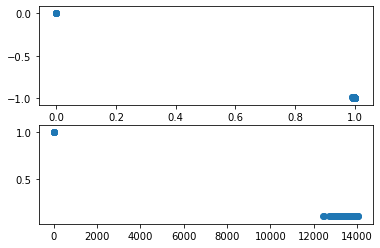

In [15]:
# Tanh, 20 embed, 128 bz, no batch_norm
encodings_traj, variances_traj = plot_trajectory(model,train_data,nEmbedding)

In [16]:
def decode(model, embedding=np.zeros((nEmbedding,))):
    with T.no_grad():
        return model.decode(T.from_numpy(embedding[None].astype(np.float32)).cuda(),collapse_time=False)[0,0].cpu().numpy()

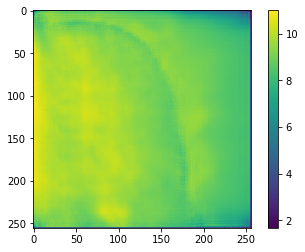

In [17]:
plt.imshow(decode(model))
plt.colorbar()

array([[3.88786316, 4.20749617, 4.57598686, ..., 2.6125083 , 2.73354053,
        1.69924438],
       [5.27451801, 4.96570969, 6.3126092 , ..., 3.70759153, 3.42013288,
        1.70793056],
       [7.14236403, 7.20493364, 7.95429325, ..., 4.69307041, 4.47822857,
        2.3663156 ],
       ...,
       [8.0466795 , 7.39443064, 8.35754967, ..., 6.09492493, 4.38665295,
        3.47871423],
       [6.38766956, 6.42464066, 7.08362579, ..., 4.30110455, 4.35203409,
        2.63711023],
       [3.13811159, 4.21676731, 4.32542658, ..., 3.68323708, 2.75574517,
        2.0664916 ]])

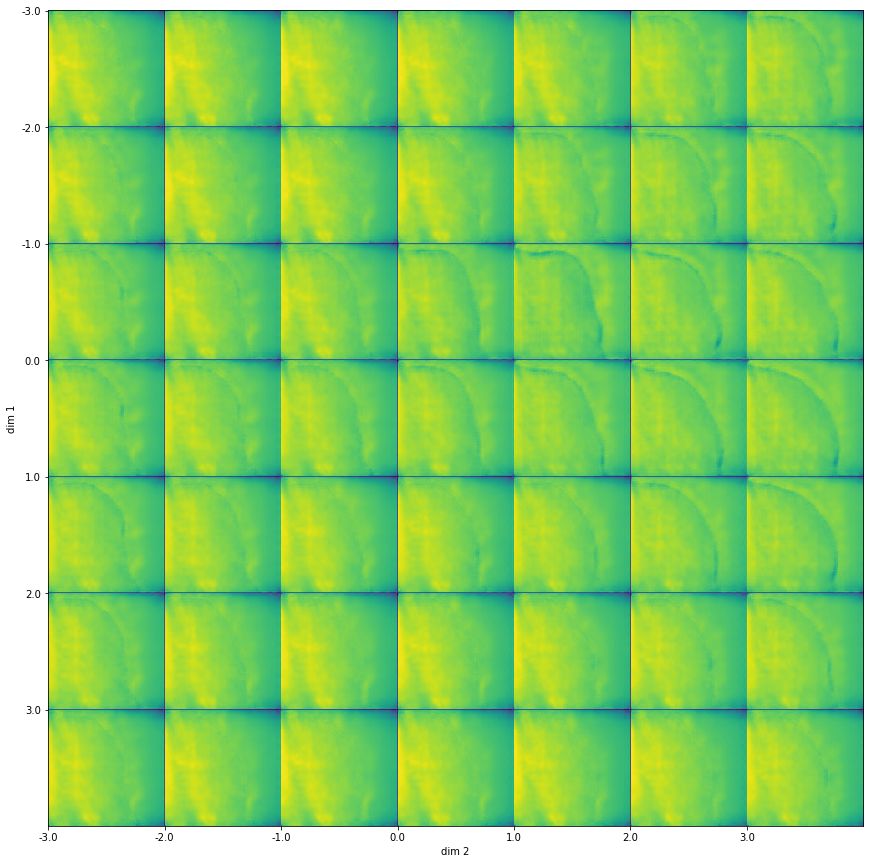

In [18]:
plot_latent(model)

data collected by Ye Tian @ Hongjie Dai

!pip install moviepy

Moviepy - Building video results/pz_kl.mp4.
Moviepy - Writing video results/pz_kl.mp4



Moviepy - Done !
Moviepy - video ready results/pz_kl.mp4


array([[4.51120682e+01, 5.52219582e+01, 4.52564316e+01, ...,
        1.55889854e+01, 6.24088812e+00, 5.29318905e+00],
       [2.15679834e+03, 2.95697583e+03, 3.19935474e+03, ...,
        8.56213684e+01, 3.01820831e+01, 4.22249374e+01],
       [3.69073535e+03, 2.77923804e+03, 3.24809204e+03, ...,
        2.16972523e+01, 2.92301273e+00, 6.36856318e+00],
       ...,
       [3.89595996e+03, 1.99908191e+03, 5.51137646e+03, ...,
        2.92116211e+02, 5.65125847e+01, 2.40179405e+01],
       [7.22408020e+02, 7.46725342e+02, 1.53095679e+03, ...,
        5.83681908e+01, 5.77017136e+01, 1.17661266e+01],
       [2.61672840e+01, 7.76430359e+01, 9.25368500e+01, ...,
        3.01722851e+01, 1.28600397e+01, 6.48379135e+00]])

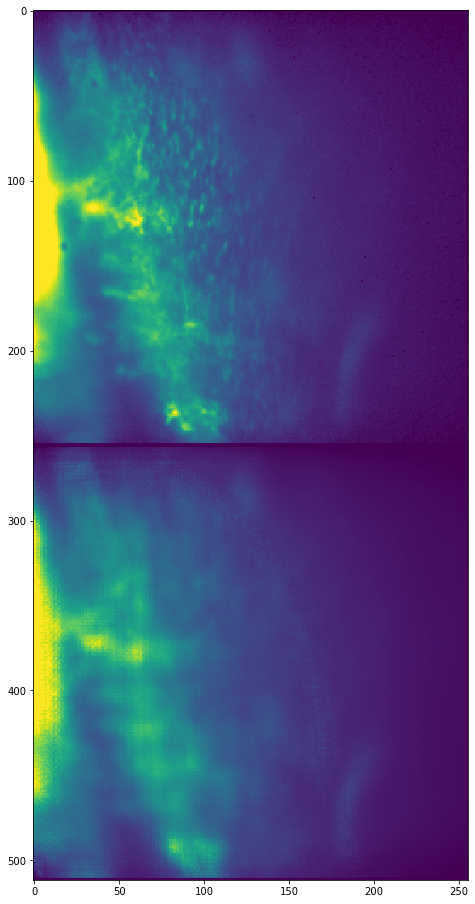

In [24]:
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage

maxVal = np.percentile(np.exp(imaging[0:500]),99.99)
minVal = np.percentile(np.exp(imaging[0:500]),0.01)

def makePredVideo(model, data, batch_size=32, num_workers=0, name="test",
                  vmin=minVal, vmax=maxVal):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    mymax = float(T.cat([data[i][0]['brain'] for i in np.arange(len(data))]).max())
    mymin = float(T.cat([data[i][0]['brain'] for i in np.arange(len(data))]).min())
    frames = []
    fig, ax = plt.subplots(figsize=(8,16))
    for b,batch_data in enumerate(dataloader):
        X, Y = batch_data
        X = X["brain"].cuda()
        Y = Y["brain"].cuda()
        with T.no_grad():
            # (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), _, _= model(X.cuda(),Y_shock.cuda())
            predicted, Xhat, Xz_mean, Xz_logvar = model(X)
        for x, xhat in zip(X,Xhat):
            # 7th z layer
            zslice = x[0,0]
            H = zslice.shape[0]
            W = zslice.shape[1]
            frame = np.zeros([H*2,W])

            frame[:H, :W] = x[0,0].exp().cpu()
            frame[H:, :W] = xhat[0,0].exp().cpu()
            ax.clear()
            im = ax.imshow(frame,vmin=vmin, vmax=vmax)
            frames.append(mplfig_to_npimage(fig))
        if b>10:
            break
    clip = mpy.ImageSequenceClip(frames,fps=20)
    clip.write_videofile(name+".mp4")
    return frame


gc.collect()
T.cuda.empty_cache()
makePredVideo(model, train_data, name="results/pz_kl")

In [65]:
maxVal

65533.00390625

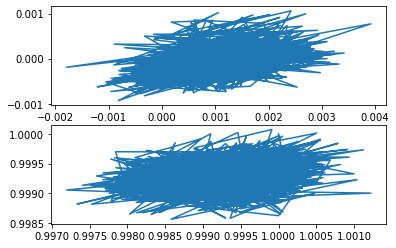

In [15]:
fig, ax = plt.subplots(2,1)
ax[0].plot(encodings_traj[:,0], encodings_traj[:,1], '-')
ax[1].plot(variances_traj[:,0], variances_traj[:,1], '-')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

x = np.linspace(0, 10, 100)
y = np.sin(x)

fig, ax = plt.subplots()
line, = ax.plot(x, y, color='k')

def update(num, x, y, line):
    line.set_data(x[:num], y[:num])
    line.axes.axis([0, 10, 0, 1])
    return line,

ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line],
                              interval=25, blit=True)
plt.show()

In [19]:
plt.rcParams['animation.ffmpeg_path'] = "/home/ubuntu/anaconda3/envs/pytorch_p36/bin/ffmpeg"

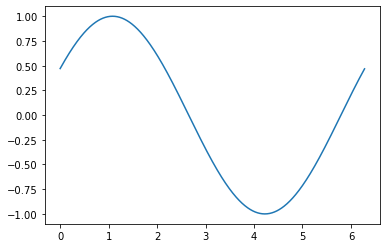

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    return line,


def animate(i):
    line.set_ydata(np.sin(x + i / 100))  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=2, blit=True, save_count=50)

# To save the animation, use e.g.
#
ani.save("/data/plots/movie.mp4")
#
# or
#
# from matplotlib.animation import FFMpegWriter
# writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

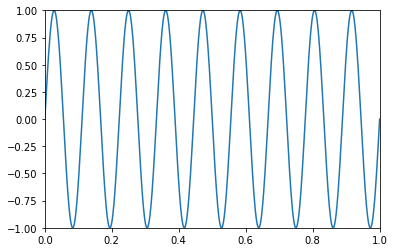

<Figure size 432x288 with 0 Axes>

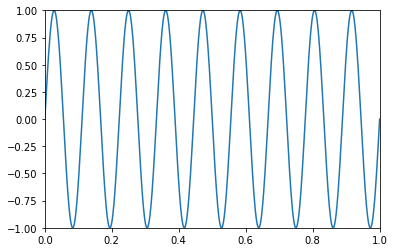

In [20]:
# Create a named display
handle = plt.figure()

x = np.linspace(0,1,1000)
y = 0*x

fig, ax = plt.subplots()
line, = ax.plot(x,y)
ax.set_xlim(0,1)
ax.set_ylim(-1,1)

for k in range(1,10):
    line.set_ydata(np.sin(2*np.pi*k*x))
    # Update the named display with a new figure
#     handle.update(fig)
    time.sleep(1)
    
fig

In [ ]:
encodings_traj.shape

In [55]:
60*120

7200